# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch06/ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크


check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:



In [39]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-07 16:14:00--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py.2’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-07 16:14:01 (22.0 MB/s) - ‘python_environment_check.py.2’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [40]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] numpy 1.23.5
[OK] matplotlib 3.7.1
[OK] sklearn 1.2.2
[OK] pandas 1.5.3


# 6장 - 모델 평가와 하이퍼파라미터 튜닝의 모범 사례


### 목차



- 파이프라인을 사용한 효율적인 워크플로
  - 위스콘신 유방암 데이터셋
  - 파이프라인으로 변환기와 추정기 연결
- k-겹 교차 검증을 사용한 모델 성능 평가
  - 홀드아웃 방법
  - k-겹 교차 검증
- 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅
  - 학습 곡선으로 편향과 분산 문제 분석
  - 검증 곡선으로 과대적합과 과소적합 조사
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
  - 그리드 서치를 사용한 하이퍼파라미터 튜닝
  - 랜덤 서치로 하이퍼파라미터 설정을 더 넓게 탐색하기
  - SH 방식을 사용한 자원 효율적인 하이퍼파라미터 탐색
  - 중첩 교차 검증을 사용한 알고리즘 선택
- 여러 가지 성능 평가 지표
  - 오차 행렬
  - 분류 모델의 정밀도와 재현율 최적화
  - ROC 곡선 그리기
  - 다중 분류의 성능 지표
  - 불균형한 클래스 다루기
- 요약

In [41]:
from IPython.display import Image
%matplotlib inline

# 파이프라인을 사용한 효율적인 워크플로


## 위스콘신 유방암 데이터셋


In [42]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [43]:
df.shape

(569, 32)

In [44]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [45]:
le.transform(['M', 'B'])

array([1, 0])

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## 파이프라인으로 변환기와 추정기 연결


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'테스트 정확도: {test_acc:.3f}')

테스트 정확도: 0.956


In [48]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_01.png', width=500)

# k-겹 교차 검증을 사용한 모델 성능 평가


## 홀드아웃 방법


In [49]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_02.png', width=500)

## k-겹 교차 검증


In [50]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_03.png', width=500)

In [51]:
import numpy as np
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    print(f'폴드: {k+1:02d}, '
          f'클래스 분포: {np.bincount(y_train[train])}, '
          f'정확도: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV 정확도: {mean_acc:.3f} +/- {std_acc:.3f}')

폴드: 01, 클래스 분포: [256 153], 정확도: 0.935
폴드: 02, 클래스 분포: [256 153], 정확도: 0.935
폴드: 03, 클래스 분포: [256 153], 정확도: 0.957
폴드: 04, 클래스 분포: [256 153], 정확도: 0.957
폴드: 05, 클래스 분포: [256 153], 정확도: 0.935
폴드: 06, 클래스 분포: [257 153], 정확도: 0.956
폴드: 07, 클래스 분포: [257 153], 정확도: 0.978
폴드: 08, 클래스 분포: [257 153], 정확도: 0.933
폴드: 09, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV 정확도 점수: {scores}')
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


<역자 노트>

---

In [53]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=10,
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']),
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


In [54]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [55]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          method='predict_proba',
                          n_jobs=-1)
preds[:10]

array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

---

# 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅


## 학습 곡선으로 편향과 분산 문제 분석


In [56]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_04.png', width=600)

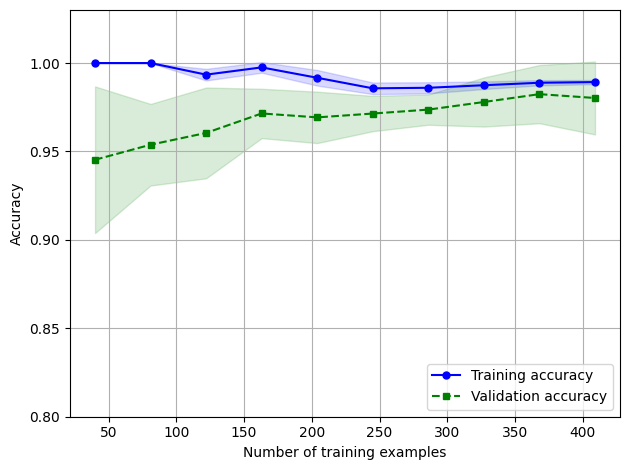

In [57]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

<역자 노트>

---

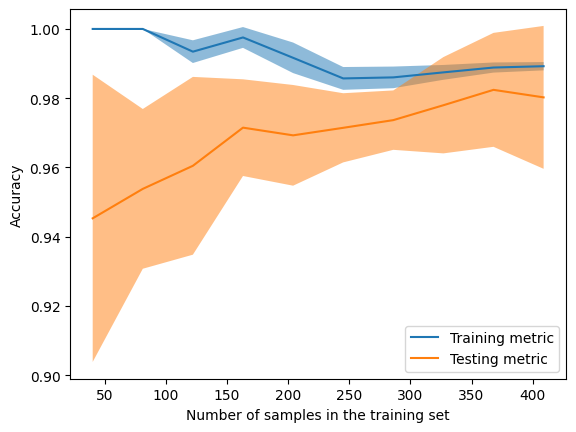

In [58]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores,
                               test_scores=test_scores,
                               score_name="Accuracy")
display.plot(score_type='both')
plt.legend(loc='lower right')
plt.show()

---

## 검증 곡선으로 과대적합과 과소적합 조사


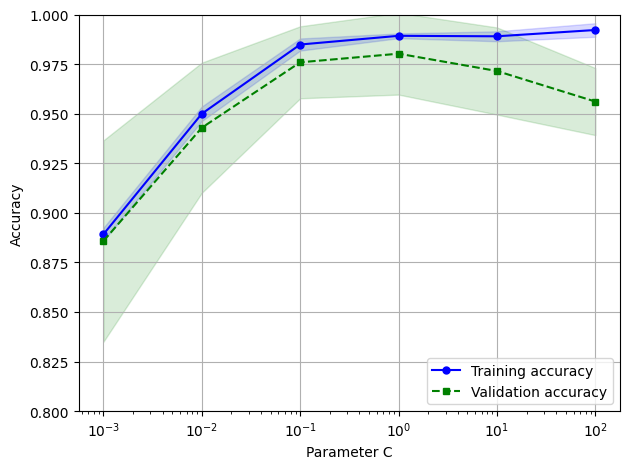

In [59]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝


## 그리드 서치를 사용한 하이퍼파라미터 튜닝


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [61]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print(f'테스트 정확도: {clf.score(X_test, y_test):.3f}')

테스트 정확도: 0.974


<역자 노트>

---

In [62]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [63]:
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [64]:
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [65]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


---

## 랜덤 서치로 하이퍼파라미터 설정을 더 넓게 탐색하기


In [66]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_11.png', width=600)

In [67]:
import scipy.stats


param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_range = scipy.stats.loguniform(0.0001, 1000.0)

np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [68]:
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

In [69]:
rs = rs.fit(X_train, y_train)
print(rs.best_score_)

0.9780676328502416


In [70]:
print(rs.best_params_)

{'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}


## SH 방식을 사용한 자원 효율적인 하이퍼파라미터 탐색


In [71]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [72]:
hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)

In [73]:
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9617647058823529
{'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}


In [74]:
clf = hs.best_estimator_
print(f'테스트 정확도: {hs.score(X_test, y_test):.3f}')

테스트 정확도: 0.982


## 중첩 교차 검증을 사용한 알고리즘 선택


In [75]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_07.png', width=500)

In [76]:
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도: 0.974 +/- 0.015


In [77]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print(f'CV 정확도: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV 정확도: 0.934 +/- 0.016


# 여러 가지 성능 평가 지표


## 오차 행렬


In [78]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch06/figures/06_08.png', width=300)

In [79]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


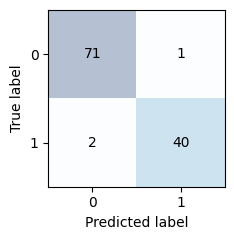

In [80]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('figures/06_09.png', dpi=300)
plt.show()

<역자 노트>

---

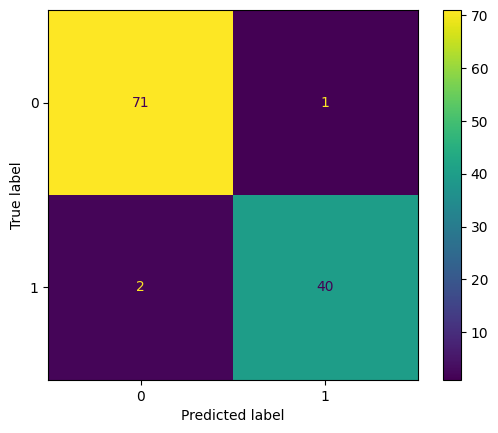

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)
plt.show()

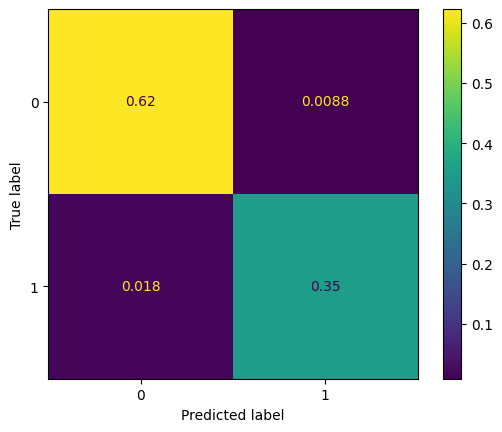

In [82]:
ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test,
                                      normalize='all')
plt.show()

---

### 추가 노트

앞서 클래스 레이블을 인코딩했기 때문에 *악성(malignant)* 종양이 "양성" 클래스(1), *양성(benign)* 종양이 "음성" 클래스(0)입니다:

In [83]:
le.transform(['M', 'B'])

array([1, 0])

In [84]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


그리고 다음처럼 오차 행렬을 출력했습니다:

In [85]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


클래스 0으로 올바르게 예측된 (진짜) 클래스 0 샘플(진짜 음성)이 행렬의 왼쪽 위에 있는 값입니다(인덱스 0,0). 진짜 음성이 오른쪽 아래(인덱스 1,1)에 있고 진짜 양성이 왼쪽 위에 있도록 순서를 바꾸려면 다음처럼 `labels` 매개변수를 사용합니다:

In [86]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


결론:

이 예에서 클래스 1(악성 종양)이 양성 클래스입니다. 모델은 71개의 샘플을 정확하게 클래스 0(진짜 음성)으로 분류했습니다. 40개의 샘플은 클래스 1(진짜 양성)로 올바르게 분류했습니다. 클래스 1에 해당하는 두 개의 샘플을 클래스 0(가짜 음성)으로 잘못 분류했고 양성 종양인 하나의 샘플을 악성 종양(가짜 양성)으로 잘못 분류했습니다.

## 분류 모델의 정밀도와 재현율 최적화


In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'정밀도: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'재현율: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

정밀도: 0.976
재현율: 0.952
F1: 0.964
MCC: 0.943


In [88]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## ROC 곡선 그리기


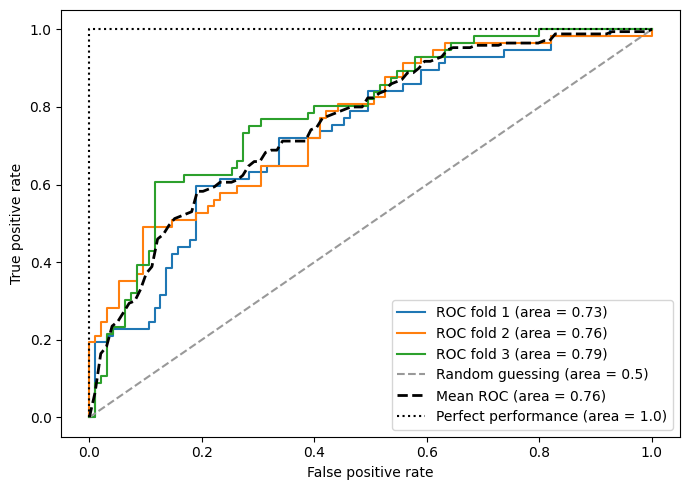

In [89]:
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
# plt.savefig('figures/06_10.png', dpi=300)
plt.show()

<역자 노트>

---

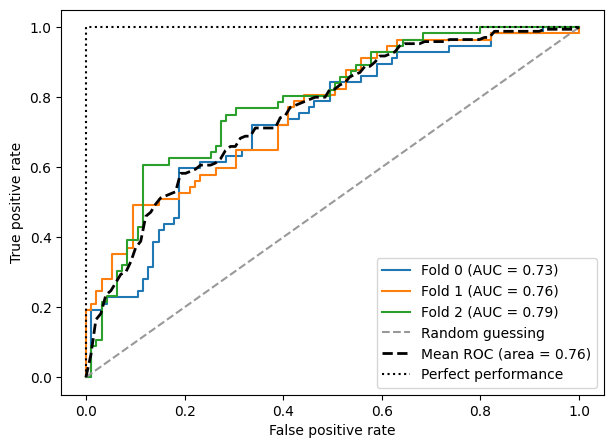

In [90]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = RocCurveDisplay.from_estimator(pipe_lr,
                                              X_train2[test], y_train[test],
                                              name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

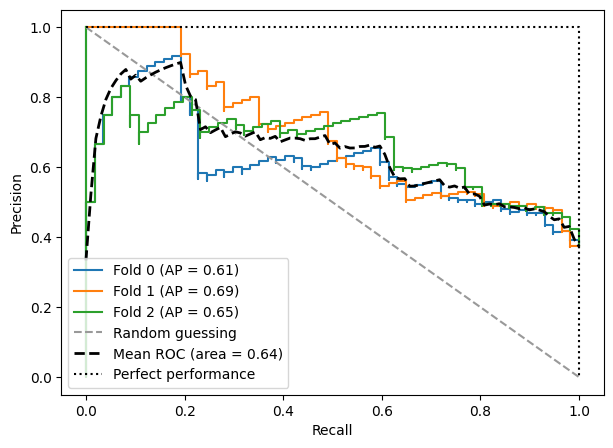

In [91]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = PrecisionRecallDisplay.from_estimator(
        pipe_lr, X_train2[test], y_train[test],
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1],
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

---

## 다중 분류의 성능 지표


In [92]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

## 불균형한 클래스 다루기


In [93]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [94]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [95]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링하기 후 클래스 1의 샘플 개수: 357


In [96]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [97]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

# 요약